<h1>K-Nearest Neighbor</h1>

<h5>Importing Packages</h5>

In [16]:
try:
    from google.colab import drive
    drive.mount('/drive', force_remount=False)
    %run "/drive/My Drive/Colab Notebooks/Notebooks/Classical Machine Learning/Classical Methods - Processing.ipynb"
except:
    %run "/Google Drive/My Drive/Colab Notebooks/Notebooks/Classical Machine Learning/Classical Methods - Processing.ipynb"

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).
In Colab: True
Work Folder: /drive/My Drive/Colab Notebooks/Experimentos/Classical Machine Learning/


<h5>Parameters</h5>

In [0]:
datasets = getDataSets()

In [0]:
sides = ['left', 'right']
neighbors_amount = [1, 2, 5, 10, 50, 100, 250, 500, 1000]
window_sizes = [100, 150, 200, 250, 300]
window_fn = experiment_by_window_fn[0]
agg_fn_dict = experiment_by_agg_fn[5]
fields = experiment_by_fields[2]
agg_fn = getAggFunctions(fields, acc=agg_fn_dict["acc"], gyro=agg_fn_dict["gyro"], speed=agg_fn_dict["speed"])
save_path = os.path.join(work_folder, "KNN")
createPathIfNotExists(save_path)
subsets = getSubSets(datasets.copy(), fields, surface_type_labels)

<h5>Execution</h5>

In [0]:
def searchBestModel(subsets, sets_train, sets_test, experiment_number, experiment_load_bar):
     
    execution_log = []
    experiment_path = os.path.join(save_path, "Experiment " + str(experiment_number)) 
    
    for window in window_sizes:

        features_set = getExtractedFeatures(subsets, window_fn, window, agg_fn, sides)
        input_train, input_test, output_train, output_test = getTrainTestSets(features_set, sets_train, sets_test, sides)

        for neighbors in neighbors_amount:
            
            model, train_acc, val_acc = trainTestModel(input_train, input_test, output_train, output_test, neighbors)
            execution_log.append([experiment_number, window, neighbors, train_acc, val_acc])
            best_model = (model, { "window": window, "neighbors": neighbors }, train_acc, val_acc)

            file_prefix = "experiment-" + str(experiment_number) + "-window-" + str(window) + "-neighbors-" + str(neighbors)
            saveBestModel(experiment_path, file_prefix, best_model)

            experiment_load_bar.update(1)
            print("Experiment", str(experiment_number), "Window", str(window), "Neighbors", str(neighbors), "Train Acc", str(best_model[2]), "Val Acc", best_model[3])
    
    saveExecutionLog(experiment_path, "experiment", execution_log, ["experiment", "window", "neighbors", "train_acc", "val_acc"])
           
def trainTestModel(x_train, x_test, y_train, y_test, neighbors):
    
    # Build model
    model = KNeighborsClassifier(n_neighbors=neighbors, n_jobs=-1)
    
    # Fit model
    model.fit(x_train.values, y_train.values)
    
    # Test model
    y_train_pred = model.predict(x_train.values) 
    y_test_pred = model.predict(x_test.values)   
    
    return model, accuracy_score(y_train, y_train_pred), accuracy_score(y_test, y_test_pred)

def run():
    
    experiment_total_iteration = len(window_sizes) * len(neighbors_amount)
    experiment_total = len(experiment_by_dataset)
    
    load_bar_main = tqdm(total=experiment_total, desc='Main Progress')
    load_bar_experiment = tqdm(total=experiment_total_iteration)
    
    experiment_number = 0
  
    for dataset_dict in experiment_by_dataset:
        experiment_number += 1
        load_bar_experiment.reset()
        load_bar_experiment.set_description("Experiment " + str(experiment_number))
        searchBestModel(subsets, dataset_dict["train"], dataset_dict["test"], experiment_number, load_bar_experiment)
        load_bar_main.update(1)

In [0]:
run()

<h5>Best Model - Confusion Matrix</h5>

In [0]:
files = [
    'experiment-1-window-200-neighbors-5-train-acc-0.8450300773-val-acc-0.7628272251.joblib',
    'experiment-2-window-200-neighbors-5-train-acc-0.8644469211-val-acc-0.7110927152.joblib',
    'experiment-3-window-200-neighbors-5-train-acc-0.8675933726-val-acc-0.7698369565.joblib'
]

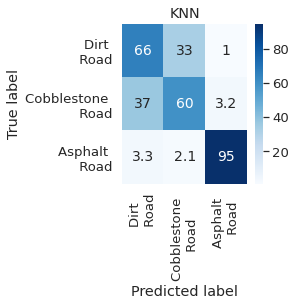

In [17]:
matrix = []
window = 200

for experiment_number in range(0,3):

    sets_train = experiment_by_dataset[experiment_number]['train']
    sets_test = experiment_by_dataset[experiment_number]['test']

    features_set = getExtractedFeatures(subsets, window_fn, window, agg_fn, sides)
    input_train, input_test, output_train, output_test = getTrainTestSets(features_set, sets_train, sets_test, sides)

    path = os.path.join(work_folder, "KNN", "Experiment " + str(experiment_number + 1))
    model = loadBestModel(path, files[experiment_number])[0]
    y_pred = model.predict(input_test.values)
    y_true = output_test.copy().values

    # print(accuracy_score(y_true, y_pred))
    matrix.append(confusion_matrix(y_true.argmax(axis=1), y_pred.argmax(axis=1), normalize="true"))

result = ((matrix[0] + matrix[1] + matrix[2])/3)*100
plotConfusionMatrix(result, "KNN")